In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

In [5]:
start = dt.datetime.now()

In [13]:
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 1987
data_dir = 'data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [14]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [15]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

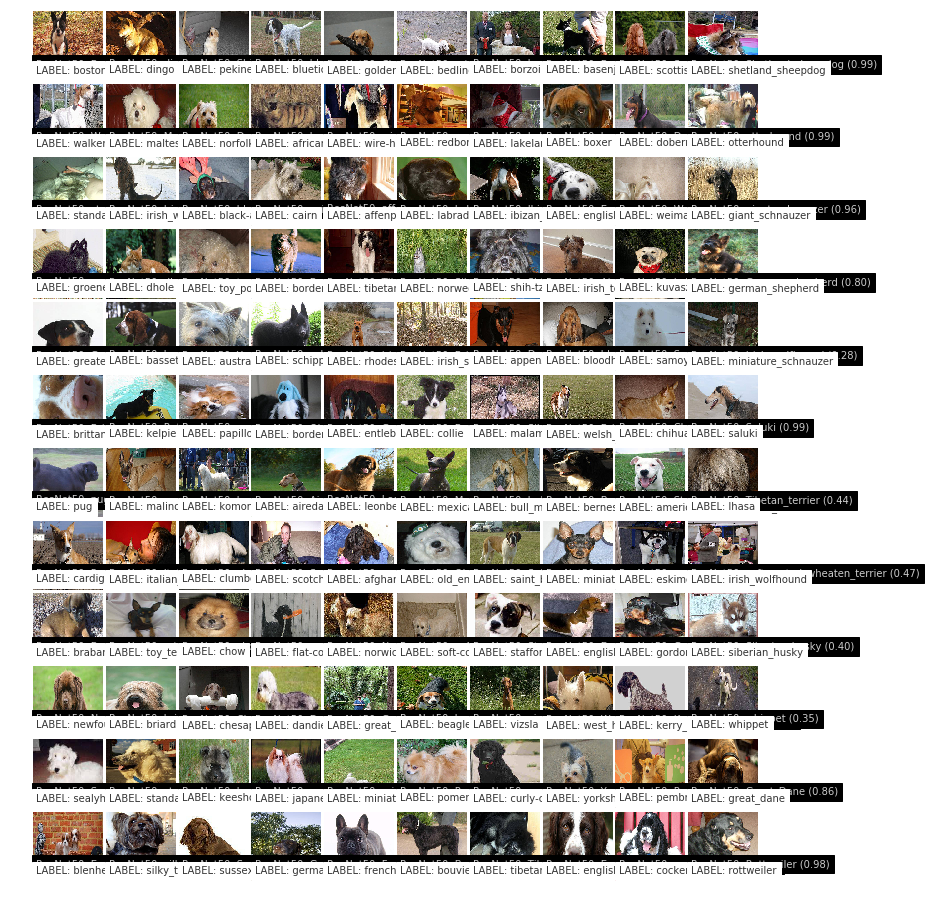

In [16]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [17]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:45, 224.03it/s]

Train Images shape: (10222, 299, 299, 3) size: 2,741,571,066


In [18]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((8140, 299, 299, 3), (2082, 299, 299, 3), (8140, 120), (2082, 120))
2082/2082 [==============================] - 13s 6ms/step
Xception train bottleneck features shape: (8140, 2048) size: 16,670,720
Xception valid bottleneck features shape: (2082, 2048) size: 4,263,936


In [19]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.354287666146487
Validation Xception Accuracy 0.8866474543707973
